# Deep Learning: Assignment #1
## Submission date: 03/12/2025, 23:59.
### Topics:
- Logistic Regression
- Feedforward Neural Networks
- Backpropagation
- Optimization
- Batch Normalization

**Submitted by:**
<font color = red>
- **Student 1 (Mahmoud Abade, 206773756)**
- **Student 2 (Feras Dwere, 214225021)**  
</font>

**Assignment Instruction:**

· Submissions are in **pairs only**. Write both names + IDs at the top of the notebook.

· Keep your code **clean, concise, and readable**.

· You may work in your IDE, but you **must** paste the final code back into the **matching notebook cells** and run it there.  


· <font color='red'>Write your textual answers in red.</font>  
(e.g., `<span style="color:red">your answer here</span>`)

· All figures, printed results, and outputs should remain visible in the notebook.  
Run **all cells** before submitting and **do not clear outputs**.

· Use relative paths — **no absolute file paths** pointing to local machines.

· **Important:** Your submission must be entirely your own.  
Any form of plagiarism (including uncredited use of ChatGPT or AI tools) will result in **grade 0** and disciplinary action.


In [9]:
# --- Global Setup ---

# Import Libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.init as init

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


## Question 1 — From Classic ML to Deep Networks

In this question we embark on a short expedition from classic Machine Learning to Deep Learning.

We will compare the performance of a **multiclass logistic regression** to a **multi-layer perceptron (MLP)** on the **MNIST** dataset.


Start by running this cell which includes relative setup and useful helper functions implemented for you to use.

In [10]:
# --- Define Seed ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# --- Helper Functions To Use ---
def accuracy(logits: torch.Tensor, y: torch.Tensor):
    """Top-1 accuracy for logits [N,C] and labels [N]."""
    return (logits.argmax(dim=1) == y).float().mean().item()

def count_params(obj):
    """
    Count trainable parameters.
    - If obj is (W, b) tuple → counts elements.
    - If obj is a nn.Module → sums requires_grad params.
    """
    if isinstance(obj, tuple) and len(obj) == 2:
        W, b = obj
        return W.numel() + b.numel()
    if isinstance(obj, nn.Module):
        return sum(p.numel() for p in obj.parameters() if p.requires_grad)
    raise TypeError("count_params expects (W,b) or nn.Module.")


@torch.no_grad()
def evaluate_acc(W: torch.Tensor, b: torch.Tensor, loader):
    """Dataset-level accuracy for a linear softmax model parameterized by (W,b)."""
    total_acc, total_n = 0.0, 0
    for xb, yb in loader:
        xb = xb.to(DEVICE).view(xb.size(0), -1)
        yb = yb.to(DEVICE)
        logits = xb @ W + b
        batch_acc = accuracy(logits, yb)
        n = xb.size(0)
        total_acc += batch_acc * n         # weight by batch size
        total_n   += n
    return total_acc / total_n


# Use this function in the training loop for your nn.Module
@torch.no_grad()
def evaluate_module(model: nn.Module, loader):
    model.eval()
    total_acc, total_n = 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        batch_acc = accuracy(logits, yb)
        n = xb.size(0)
        total_acc += batch_acc * n
        total_n   += n
    return total_acc / total_n

### Load & Preprocess the Data:



We first load the MNIST dataset as provided by `torchvision`. All images are automatically converted to tensors in the range $[0,1]$.


In [11]:
# Load the raw MNIST dataset
transform = transforms.ToTensor()

train_full = datasets.MNIST(root="./data", train=True,  download=True, transform=transform)
test_set   = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

print(f"\n Train set: {len(train_full)} samples  |  Test set: {len(test_set)} samples")

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.90MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.88MB/s]


 Train set: 60000 samples  |  Test set: 10000 samples


Implement the following steps:

1. **Split the data:**
   - The MNIST test set is already provided.
   - From the full training set, create an 80/20 split into **train** and **validation** subsets.

2. **Construct `DataLoader` objects:**
   - `train_loader` → use shuffling.
   - `val_loader` → no shuffling.
   - `test_loader` → no shuffling.2.

3. **Print a quick sanity check:**
   - batch shapes `(batch_size = 128, 1, 28, 28)`
   - label range (0–9)

*Example format:*
```python
Batch: torch.Size([128, 1, 28, 28]) torch.Size([128]) | pixel range = (0.0, 1.0)


In [12]:
# Split the training data
train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
train_set, val_set = random_split(train_full, [train_size, val_size])

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Sanity check
xb, yb = next(iter(train_loader))
print(f"Batch: {xb.shape} {yb.shape} | pixel range = ({xb.min():.1f}, {xb.max():.1f})")

Batch: torch.Size([128, 1, 28, 28]) torch.Size([128]) | pixel range = (0.0, 1.0)


###  Multiclass Logistic Regression



In binary logistic regression, we model  
$$
P(y=1 \mid x) = \sigma(w^\top x + b)
$$
where  $\sigma$ is the sigmoid activation function.

For **multiclass** problems, like ours where MNIST is a dataset of images of 10 digits, hence 10 classes, we generalize this idea.

Each class $c \in \{0, \dots, 9\}$ has its own weight vector  $w_c$ and bias  $b_c$.

We stack them into a **weight matrix**  $W \in \mathbb{R}^{d \times C}$
and a **bias vector**  $b \in \mathbb{R}^{C}$.

<br>

Generally speaking, we compute a forward pass by computing:

$$
z_i = W^\top x_i + b
$$

where $W \in \mathbb{R}^{d \times C}$ is the weight matrix and $b \in \mathbb{R}^C$ is the bias vector.

<br>

We then obtain class probabilities via the softmax function:

$$
p_i(c) = \frac{e^{z_i(c)}}{\sum_{k=1}^{C} e^{z_i(k)}}
$$

The model is trained by minimizing the **cross-entropy loss** between the predicted probabilities and the true class labels:

$$
\mathcal{L}(W,b) = -\frac{1}{N} \sum_{i=1}^N \log p_i(y_i)
$$

and the parameters are updated using **gradient descent**:

$$
W \leftarrow W - \eta \, \nabla_W \mathcal{L}, \qquad
b \leftarrow b - \eta \, \nabla_b \mathcal{L}
$$


<br><br>
In this question, you will build a multiclass logistic regression model from scratch, train it using the cross-entropy loss, and optimize it with gradient descent.

<br>

You will then evaluate the model’s performance on the MNIST dataset, and train it on 20 epochs.


In [13]:
def logistic_regression(train_loader, val_loader, epochs=20, lr=0.1, tol=1e-6):
    """
    Train a multiclass logistic regression model using gradient descent.
    - X: [N, d] input features (flattened images)
    - y: [N] class labels in {0,...,9}
    - lr: learning rate
    - max_steps: max number of iterations
    - tol: stop early when gradients converge

    Returns: (W, b)
    """
    d = 784  # MNIST image size
    C = 10   # Number of classes

    # Initialize parameters
    W = torch.randn(d, C, device=DEVICE, requires_grad=True)
    b = torch.zeros(C, device=DEVICE, requires_grad=True)

    for epoch in range(epochs):
        for xb, yb in train_loader:
            xb = xb.to(DEVICE).view(xb.size(0), -1)
            yb = yb.to(DEVICE)

            # Forward pass
            logits = xb @ W + b
            loss = F.cross_entropy(logits, yb)

            # Backward pass
            loss.backward()

            # Update weights
            with torch.no_grad():
                W -= lr * W.grad
                b -= lr * b.grad
                W.grad.zero_()
                b.grad.zero_()

        val_acc = evaluate_acc(W, b, val_loader)
        print(f"Epoch {epoch+1}/{epochs} | Val acc: {val_acc:.4f}")

    return W.detach(), b.detach()


Now run the next cell to evaluate your multiclass logistic regression.

We use the `evaluate_acc` helper function to evaluate.


In [14]:
# TODO: Run
W, b = logistic_regression(train_loader, val_loader, epochs=20, lr=0.1)

model = (W, b)

# Evaluate
val_acc  = evaluate_acc(W, b, val_loader)
test_acc = evaluate_acc(W, b, test_loader)

print(f"\nNumber of Parameters: {count_params(model):,}")
print(f"Val. acc.: {val_acc:.4f}")
print(f"Test acc.: {test_acc:.4f}")

Epoch 1/20 | Val acc: 0.6871
Epoch 2/20 | Val acc: 0.7658
Epoch 3/20 | Val acc: 0.7996
Epoch 4/20 | Val acc: 0.8166
Epoch 5/20 | Val acc: 0.8297
Epoch 6/20 | Val acc: 0.8379
Epoch 7/20 | Val acc: 0.8455
Epoch 8/20 | Val acc: 0.8494
Epoch 9/20 | Val acc: 0.8542
Epoch 10/20 | Val acc: 0.8565
Epoch 11/20 | Val acc: 0.8602
Epoch 12/20 | Val acc: 0.8628
Epoch 13/20 | Val acc: 0.8665
Epoch 14/20 | Val acc: 0.8684
Epoch 15/20 | Val acc: 0.8685
Epoch 16/20 | Val acc: 0.8718
Epoch 17/20 | Val acc: 0.8732
Epoch 18/20 | Val acc: 0.8726
Epoch 19/20 | Val acc: 0.8748
Epoch 20/20 | Val acc: 0.8772

Number of Parameters: 7,850
Val. acc.: 0.8772
Test acc.: 0.8914


Answer the following questions:

1. Is a *logistic regression* a sufficient model for this task?  
   What **constraints** does this model impose on the decision boundaries and on what it can “represent”?  
   What **modification** might help address these constraints?


2. Give two examples of incorrectly classified digits. Include the image of the misclassified digit,
the predicted class and the actual class in your write up

</br>

<font color='red'>
1.  **Is logistic regression sufficient ?** No, it's not ideal. While it performs better than random guessing, a validation accuracy of ~88% isn't state-of-the-art for MNIST.  
    **Some Constraints:** Logistic regression imposes a linear decision boundary. It can only separate classes that are linearly separable. For complex, non-linear data like MNIST digits (think of the variations in handwriting for the same digit), a linear model is too simple.  
    **Modification:** Introducing non-linearity, for instance, by adding hidden layers with non-linear activation functions (like in a neural network), would allow the model to learn more complex decision boundaries.

2.  **Incorrectly classified digits:** As shown in the example below we can see that some images were incorrectly classified

</font>

Two examples of incorrectly classified digits: 


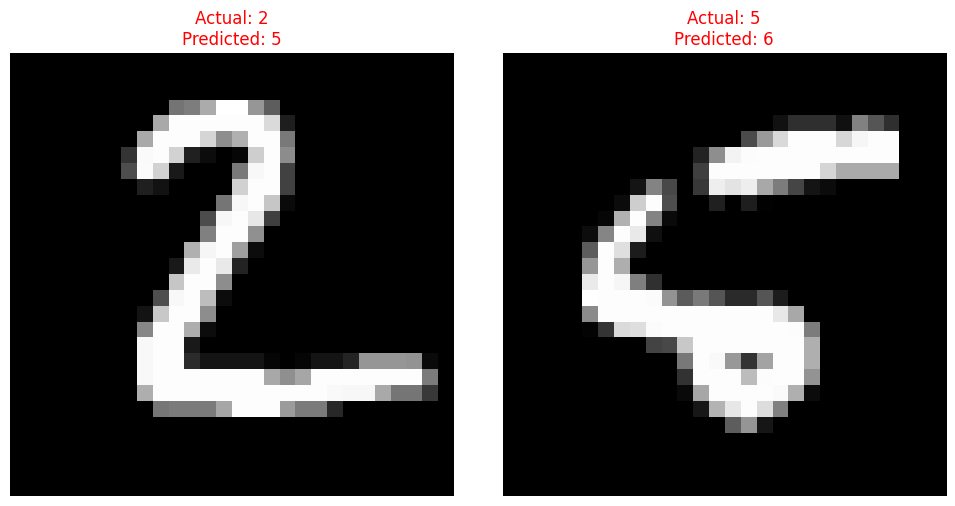

In [15]:
misclassified_examples = []

@torch.no_grad()
def find_misclassified(W, b, loader, num_examples=2):
    W = W.to(DEVICE)
    b = b.to(DEVICE)
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        # Flatten images for logistic regression
        xb_flat = xb.view(xb.size(0), -1)

        # Forward pass
        logits = xb_flat @ W + b
        predictions = logits.argmax(dim=1)

        # Identify misclassified samples
        incorrect_indices = (predictions != yb).nonzero(as_tuple=True)[0]

        for idx in incorrect_indices:
            if len(misclassified_examples) < num_examples:
                # Detach from GPU and convert to numpy for plotting
                misclassified_examples.append({
                    'image': xb[idx].cpu().squeeze().numpy(),
                    'predicted': predictions[idx].item(),
                    'actual': yb[idx].item()
                })
            else:
                return misclassified_examples # Found enough examples
    return misclassified_examples


misclassified_samples = find_misclassified(W, b, test_loader, num_examples=2)


print("Two examples of incorrectly classified digits: ")

fig, axes = plt.subplots(1, len(misclassified_samples), figsize=(10, 5))
for i, example in enumerate(misclassified_samples):
    ax = axes[i]
    ax.imshow(example['image'], cmap='gray')
    ax.set_title(f"Actual: {example['actual']}\nPredicted: {example['predicted']}", color='red')
    ax.axis('off')
plt.tight_layout()
plt.show()

### Feedforward Neural Network




As we learned in class, a **Feedforward Neural Network (FFNN)** maps an input — in our case, a flattened $28 \times 28$ image, $x \in \mathbb{R}^{784}$ — through a sequence of **linear layers** interleaved with **nonlinear activation functions**.

Formally, the computation proceeds as follows:

$$
y^{(1)} = \sigma (W^{(1)}x+b^{(1)})
$$
$$
y^{(\ell)} = \sigma (W^{(1)}y^{(\ell -1)}+b^{(1)})
$$


Where:
- $y^{(i)}$ is the output of layer $i$.
- $W^{(i)}$ and $b^{(i)}$ are the weight matrix and bias vector for layer $i$, respectively.
- $\sigma ^{(i)}$ is the activation function used in layer $i$.

In this section you will implement a FFNN from scratch, and see how it fairs with the MNIST dataset.

In the cell below, implement your `MLP` network, a two-layer Multi-Layer Perceptron with no regularization to classify MNIST with the following architecture:

- Input layer : 784 nodes (MNIST images size)
- First hidden layer : 400 nodes
- Second hidden layer : 400 nodes
- Output layer : 10 nodes (number of classes for MNIST)


<br>

- Use `RELU()` as your activation function for each layer.

In [16]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 400),
            nn.ReLU(),
            nn.Linear(400, 10)
        )

    def forward(self, x):
        return self.model(x)

After defining `MLP` class, train it for **20 epochs** using **cross-entropy loss** and **Adam** as your optimizer.  

At the end of every epoch, evaluate the model both on the training set and on the validation set. You should print the loss, the training accuracy, and the validation accuracy so that you can monitor how the model improves over time and detect potential overfitting.

Once training is complete, produce a plot that shows how the training accuracy and the validation accuracy evolve across the 20 epochs. The plot should clearly reflect the learning dynamics of your model and allow you to compare its performance to the logistic regression model from the previous section.

> You already have the helpers `evaluate_module`, `accuracy`, and `count_params` in the setup cell— you may use them directly in your implementation.


Epoch 1/20 | Train acc: 0.9600 | Val acc: 0.9508
Epoch 2/20 | Train acc: 0.9788 | Val acc: 0.9663
Epoch 3/20 | Train acc: 0.9866 | Val acc: 0.9722
Epoch 4/20 | Train acc: 0.9902 | Val acc: 0.9723
Epoch 5/20 | Train acc: 0.9917 | Val acc: 0.9742
Epoch 6/20 | Train acc: 0.9940 | Val acc: 0.9751
Epoch 7/20 | Train acc: 0.9949 | Val acc: 0.9753
Epoch 8/20 | Train acc: 0.9934 | Val acc: 0.9737
Epoch 9/20 | Train acc: 0.9968 | Val acc: 0.9782
Epoch 10/20 | Train acc: 0.9971 | Val acc: 0.9773
Epoch 11/20 | Train acc: 0.9967 | Val acc: 0.9768
Epoch 12/20 | Train acc: 0.9952 | Val acc: 0.9737
Epoch 13/20 | Train acc: 0.9945 | Val acc: 0.9738
Epoch 14/20 | Train acc: 0.9973 | Val acc: 0.9761
Epoch 15/20 | Train acc: 0.9984 | Val acc: 0.9785
Epoch 16/20 | Train acc: 0.9959 | Val acc: 0.9756
Epoch 17/20 | Train acc: 0.9969 | Val acc: 0.9762
Epoch 18/20 | Train acc: 0.9979 | Val acc: 0.9758
Epoch 19/20 | Train acc: 0.9985 | Val acc: 0.9798
Epoch 20/20 | Train acc: 0.9991 | Val acc: 0.9811

Test acc

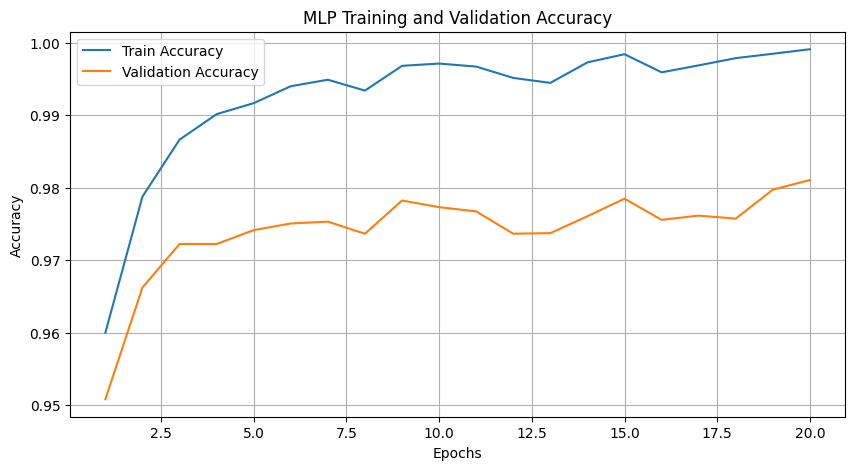

In [17]:
model = MLP().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
epochs = 20

train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = loss_fn(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_acc = evaluate_module(model, train_loader)
    val_acc = evaluate_module(model, val_loader)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Val acc: {val_acc:.4f}")

test_acc = evaluate_module(model, test_loader)
print(f"\nTest acc.: {test_acc:.4f}")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MLP Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

<font color="red">Answer the following questions:</font>

<ol>
  <li>
    <font color='red'>
    **Why it outperforms:** The MLP achieves a significantly higher accuracy (~98%) compared to the logistic regression model (~87%). This is because the MLP can learn non-linear decision boundaries, which are essential for classifying complex data like MNIST.  
    **Key property:** The key property is the use of hidden layers with non-linear activation functions (ReLU in this case). These allow the model to learn a hierarchical representation of the data, capturing more intricate patterns than a simple linear model. The plot clearly shows the MLP's validation accuracy surpassing the logistic regression's final accuracy within just a few epochs.
    </font>
  </li>
<br>
  <li>
    <font color='red'>
    **Did you need all 20 epochs?** Not necessarily. The validation accuracy starts to plateau around epoch 10-12. After this point, the training accuracy continues to increase while the validation accuracy stagnates, which is a sign of overfitting.  
    **Stopping point:** A good stopping point would be around epoch 10.  
    **Rule:** A common technique is **early stopping**. We can monitor the validation accuracy and stop training if it doesn't improve for a certain number of consecutive epochs (e.g., 3-5 epochs). This 'patience' value prevents premature stopping due to small fluctuations.
    </font>
  </li>
</ol>


### Exploring Initialization

Now, we’ll explore how **weight initialization** affects training dynamics and accuracy. In this section, you will expirement with different initilization methods, **changing only the initialization scheme** while keeping **everything else fixed**, including the model architecture, optimizer, data splits, number of epochs, batch size, etc.

<br>

In the previous code, you used PyTorch’s default: **Kaiming/He initialization**, which scales weights so that
$$
\mathrm{Var}(W_{ij}) \approx \frac{2}{\text{fan}_{in}}
$$
to help stabilize activations and gradients with ReLU layers.

In this section, you'll compare this baseline to four alternatives:
1. Zero initialization
2. Uniform $[0,1]$
3. Standard Normal: $\mathcal{N}(0,1)$
4. Xavier initialization

For each scheme, reinitialize <strong>all</strong> linear layers (weights and biases), train for 20 epochs using adam optimizer, and record validation accuracy per epoch and the final test accuracy. Then plot all validation-accuracy curves on one figure, report the final test accuracies for each method.

> Tip: Recreate a **fresh model** for each initialization; don’t re-use trained weights between runs.

Default (Kaiming) | Test acc: 0.9753
Zero | Test acc: 0.1135
Uniform | Test acc: 0.8829
Normal | Test acc: 0.9502
Xavier | Test acc: 0.9804


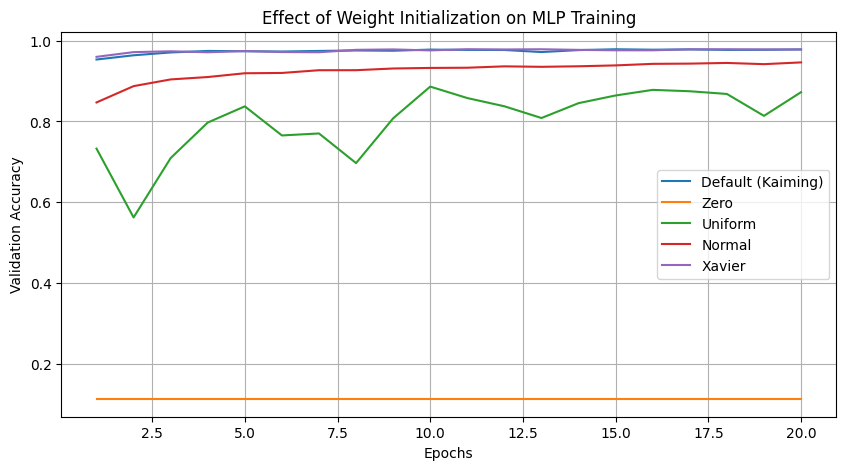

In [18]:
def train_with_init(init_fn, title):
    model = MLP().to(DEVICE)
    if init_fn is not None:
        model.apply(init_fn)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    epochs = 20
    val_accs = []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        val_acc = evaluate_module(model, val_loader)
        val_accs.append(val_acc)

    test_acc = evaluate_module(model, test_loader)
    print(f"{title} | Test acc: {test_acc:.4f}")
    return val_accs

def init_zero(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 0)
        nn.init.constant_(m.bias, 0)

def init_uniform(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, 0, 1)
        nn.init.uniform_(m.bias, 0, 1)

def init_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 1)
        nn.init.normal_(m.bias, 0)

def init_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

val_accs_default = train_with_init(None, "Default (Kaiming)")
val_accs_zero = train_with_init(init_zero, "Zero")
val_accs_uniform = train_with_init(init_uniform, "Uniform")
val_accs_normal = train_with_init(init_normal, "Normal")
val_accs_xavier = train_with_init(init_xavier, "Xavier")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), val_accs_default, label='Default (Kaiming)')
plt.plot(range(1, 21), val_accs_zero, label='Zero')
plt.plot(range(1, 21), val_accs_uniform, label='Uniform')
plt.plot(range(1, 21), val_accs_normal, label='Normal')
plt.plot(range(1, 21), val_accs_xavier, label='Xavier')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Effect of Weight Initialization on MLP Training')
plt.legend()
plt.grid(True)
plt.show()

<font color="red">Answer the following question:</font>

Why does zero initialization cause training to fail, even though the optimizer still updates the weights?
<br>
<font color='red'>
If all weights are initialized to zero, all neurons in a layer will have the same output and the same gradient during backpropagation. This means that all weights will be updated in the same way, and the neurons will never learn different features. This is known as the **symmetry problem**. The network effectively behaves like a linear model, as all neurons are identical, and it cannot learn the complex patterns required for tasks like MNIST classification.
</font>

### Exploring Optimization Methods


Finally, we’ll explore how **different Optimization** methods affect training dynamics and accuracy. In this section, you will expirement with different optimizers, **changing only the optimization method** while keeping **everything else fixed**, including the model architecture, selecting the best initialization scheme you got earlier, data splits, number of epochs, batch size, etc.

<br>

Up to this point, you used the **Adam** optimizer. Here, you will experiment with alternative optimizers and compare their performance under the same settings.

In this section, you'll compare this baseline to three other alternatives:
1. Stochastic Gradient Descent (SGD)
2. RMSProp
3. Adagrad


As you did with initilization exploring, for each optimizer, create a **fresh model** and apply the **same fixed initialization** to all `nn.Linear` layers (weights & biases). Train the model for **20 epochs**. Plot all **validation-accuracy vs. epoch** curves on one figure and compare test accuracies.

> Tip: Recreate a **fresh model** for each initialization; don’t re-use trained weights between runs.

SGD | Test acc: 0.9782
RMSProp | Test acc: 0.9820
Adagrad | Test acc: 0.9815


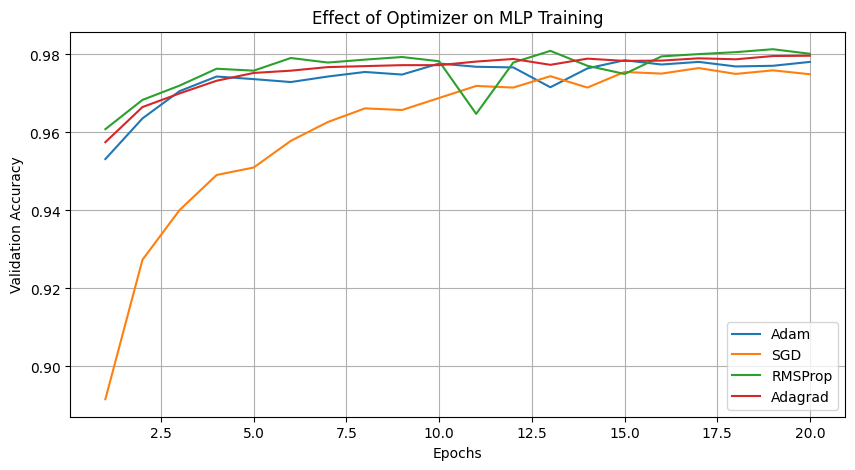

In [19]:
def train_with_optimizer(optimizer_class, title, **kwargs):
    model = MLP().to(DEVICE) # Using default Kaiming init
    optimizer = optimizer_class(model.parameters(), **kwargs)
    loss_fn = nn.CrossEntropyLoss()
    epochs = 20
    val_accs = []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        val_acc = evaluate_module(model, val_loader)
        val_accs.append(val_acc)

    test_acc = evaluate_module(model, test_loader)
    print(f"{title} | Test acc: {test_acc:.4f}")
    return val_accs

val_accs_adam = val_accs_default # From previous run
val_accs_sgd = train_with_optimizer(optim.SGD, "SGD", lr=0.1)
val_accs_rmsprop = train_with_optimizer(optim.RMSprop, "RMSProp", lr=1e-3)
val_accs_adagrad = train_with_optimizer(optim.Adagrad, "Adagrad", lr=1e-2)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), val_accs_adam, label='Adam')
plt.plot(range(1, 21), val_accs_sgd, label='SGD')
plt.plot(range(1, 21), val_accs_rmsprop, label='RMSProp')
plt.plot(range(1, 21), val_accs_adagrad, label='Adagrad')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Effect of Optimizer on MLP Training')
plt.legend()
plt.grid(True)
plt.show()

#### Reflection

Consider the interaction between initialization and optimization:

- Combine the **best-performing initialization** with the **worst-performing optimizer**.
- Combine the **worst-performing initialization** with the **best-performing optimizer**.

Run both experiments and compare the learning dynamics.



Kaiming + SGD | Test acc: 0.9798
Zero + Adam | Test acc: 0.1135
Uniform + Adam | Test acc: 0.8776


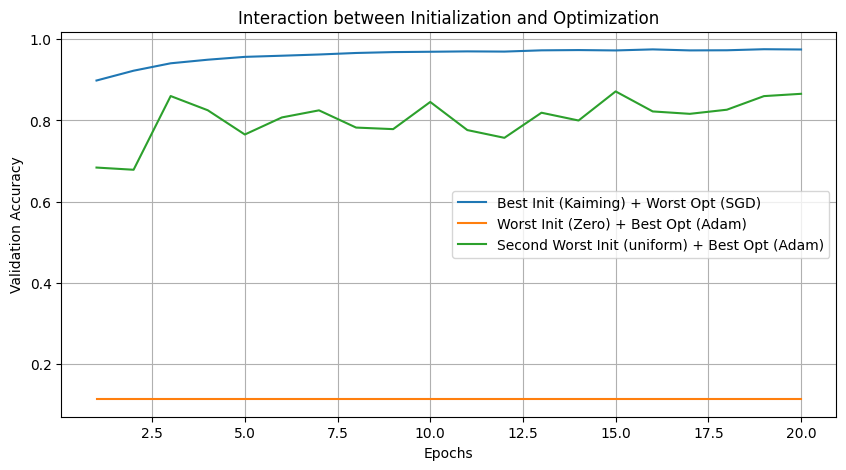

In [20]:
# Best init (Kaiming) + worst optimizer (SGD)
val_accs_best_init_worst_opt = train_with_optimizer(optim.SGD, "Kaiming + SGD", lr=0.1)

# Worst init (Zeros and uniform) + best optimizer (Adam)
val_accs_worst_init_best_opt = train_with_init(init_zero, "Zero + Adam")
val_accs_second_worst_init_best_opt = train_with_init(init_uniform, "Uniform + Adam")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), val_accs_best_init_worst_opt, label='Best Init (Kaiming) + Worst Opt (SGD)')
plt.plot(range(1, 21), val_accs_worst_init_best_opt, label='Worst Init (Zero) + Best Opt (Adam)')
plt.plot(range(1, 21), val_accs_second_worst_init_best_opt, label='Second Worst Init (uniform) + Best Opt (Adam)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Interaction between Initialization and Optimization')
plt.legend()
plt.grid(True)
plt.show()

## Question 2:  Multidimentional XOR and backpropagation

Given $ d $ bits $b=(b_1, b_2, ... , b_d) \in \{0, 1\}^d$, we define $$XOR(b) = Σ_{i=1}^db_i\ mod\ 2$$

In this question, you will train a feedforward neural network to model the multidimensional XOR problem.




The following function returns the labeled XOR "dataset" for any given $d$ (`dim`)

In [21]:
def XORData(dim):
  X = np.array(list(itertools.product([0, 1], repeat=dim)))
  Y = X.sum(axis=1)%2
  return X, Y

Implement the following:

1. A linear layer class:`Linear(torch.nn.Module)`\
• You should inherit from `torch.nn.Module`\
• You can not use `torch.nn.LinearLayer` or any other model implemented by PyTorch, only tensors. Wrap every tensor object with `torch.nn.Parameter` (for the optimizer).\
• Use `torch.randn` to initialize the parameter tensors (weights matrix and biases vector)\
• Implement the `forward` method according to the linear model $y = Wx + b$\
• The number of parameters should be defined by `in_features` and `out_features` \
• Make sure to enable gradient computation!

In [22]:
class Linear(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(out_features, in_features))
    self.bias = nn.Parameter(torch.randn(out_features))

  def forward(self, x):
    return F.linear(x, self.weight, self.bias)

2. A feedforward neural network:`FFNet(torch.nn.module)`\
• Use the `Linear` class you implemented to construct a network with `in_features` input size, `out_features` output size, and one hidden layer with `hidden_size` neurons.\
• Use the sigmoid activation function on top of the hidden layer neurons.

In [23]:
class FFNet(nn.Module):
  def __init__(self, in_features, out_features, hidden_size):
    super().__init__()
    self.layer1 = Linear(in_features, hidden_size)
    self.layer2 = Linear(hidden_size, out_features)

  def forward(self, x):
    x = self.layer1(x)
    x = torch.sigmoid(x)
    x = self.layer2(x)
    return x

### Exploring the hidden layer
In class we discussed the **Universal Approximation Theorem**. The following question will help us to understand how hard it is to find the optimal weight mentioned in the theorem.

You are given a basic training function:

In [24]:
loss_func = nn.MSELoss()

def train_and_collect_losses(net, X_data, Y_data, optimizer_instance, epochs=300):
  steps = X_data.shape[0]
  loss_history = []
  # Convert numpy arrays to torch tensors once, and move to device
  X_tensor = torch.tensor(X_data, dtype=torch.float32).to(DEVICE)
  Y_tensor = torch.tensor(Y_data, dtype=torch.float32).unsqueeze(1).to(DEVICE) # unsqueeze for MSELoss

  for i in range(epochs):
      # Randomly select a data point for each step, as in the original train function
      epoch_loss_sum = 0.0
      for j in range(steps): # Iterate 'steps' times, each time picking a random data point
          data_point_idx = np.random.randint(X_tensor.size(0))
          x_var = X_tensor[data_point_idx]
          y_var = Y_tensor[data_point_idx]

          optimizer_instance.zero_grad()
          y_hat = net(x_var)
          loss = loss_func(y_hat, y_var)
          loss.backward()
          optimizer_instance.step()
          epoch_loss_sum += loss.item()

      # Average loss over the 'steps' iterations for epoch reporting
      avg_epoch_loss = epoch_loss_sum / steps
      loss_history.append(avg_epoch_loss)

      if(i % 100 == 0):
          print(f"  Epoch:{i}, Loss:{avg_epoch_loss:.4f}")
  return loss_history

Using the code above, for each of the dimensions: $d = 2, 3, 4, 5$:
1. Create the corresponding dataset using `XORData`
2. Create models with different hidden layer sizes($1, 2, 3, ..., d,d+const, const*d,...$ etc.) and an optimizer for it using: `optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
`
3. Try to train the different networks on the dataset.
4. Plot the losses for different models on the same grid. Reflect on your findings.

Make sure to create a new `FFNet` and optimizer objects each time you call `train`.


--- Dimension d=2 ---
  Training for hidden_size=1...
  Epoch:0, Loss:1.4481
  Epoch:100, Loss:0.2684
  Epoch:200, Loss:0.2106
  Training for hidden_size=2...
  Epoch:0, Loss:0.6771
  Epoch:100, Loss:0.6409
  Epoch:200, Loss:0.3021
  Training for hidden_size=3...
  Epoch:0, Loss:0.2218
  Epoch:100, Loss:0.3188
  Epoch:200, Loss:0.2002
  Training for hidden_size=4...
  Epoch:0, Loss:0.9977
  Epoch:100, Loss:0.2803
  Epoch:200, Loss:0.0001
  Training for hidden_size=5...
  Epoch:0, Loss:0.1516
  Epoch:100, Loss:0.0246
  Epoch:200, Loss:0.0000
  Training for hidden_size=6...
  Epoch:0, Loss:0.4284
  Epoch:100, Loss:0.2534
  Epoch:200, Loss:0.0000
  Training for hidden_size=7...
  Epoch:0, Loss:0.1890
  Epoch:100, Loss:0.0005
  Epoch:200, Loss:0.0000
--- Dimension d=3 ---
  Training for hidden_size=1...
  Epoch:0, Loss:1.2598
  Epoch:100, Loss:0.2818
  Epoch:200, Loss:0.3488
  Training for hidden_size=2...
  Epoch:0, Loss:2.0383
  Epoch:100, Loss:0.2707
  Epoch:200, Loss:0.4223
  Training 

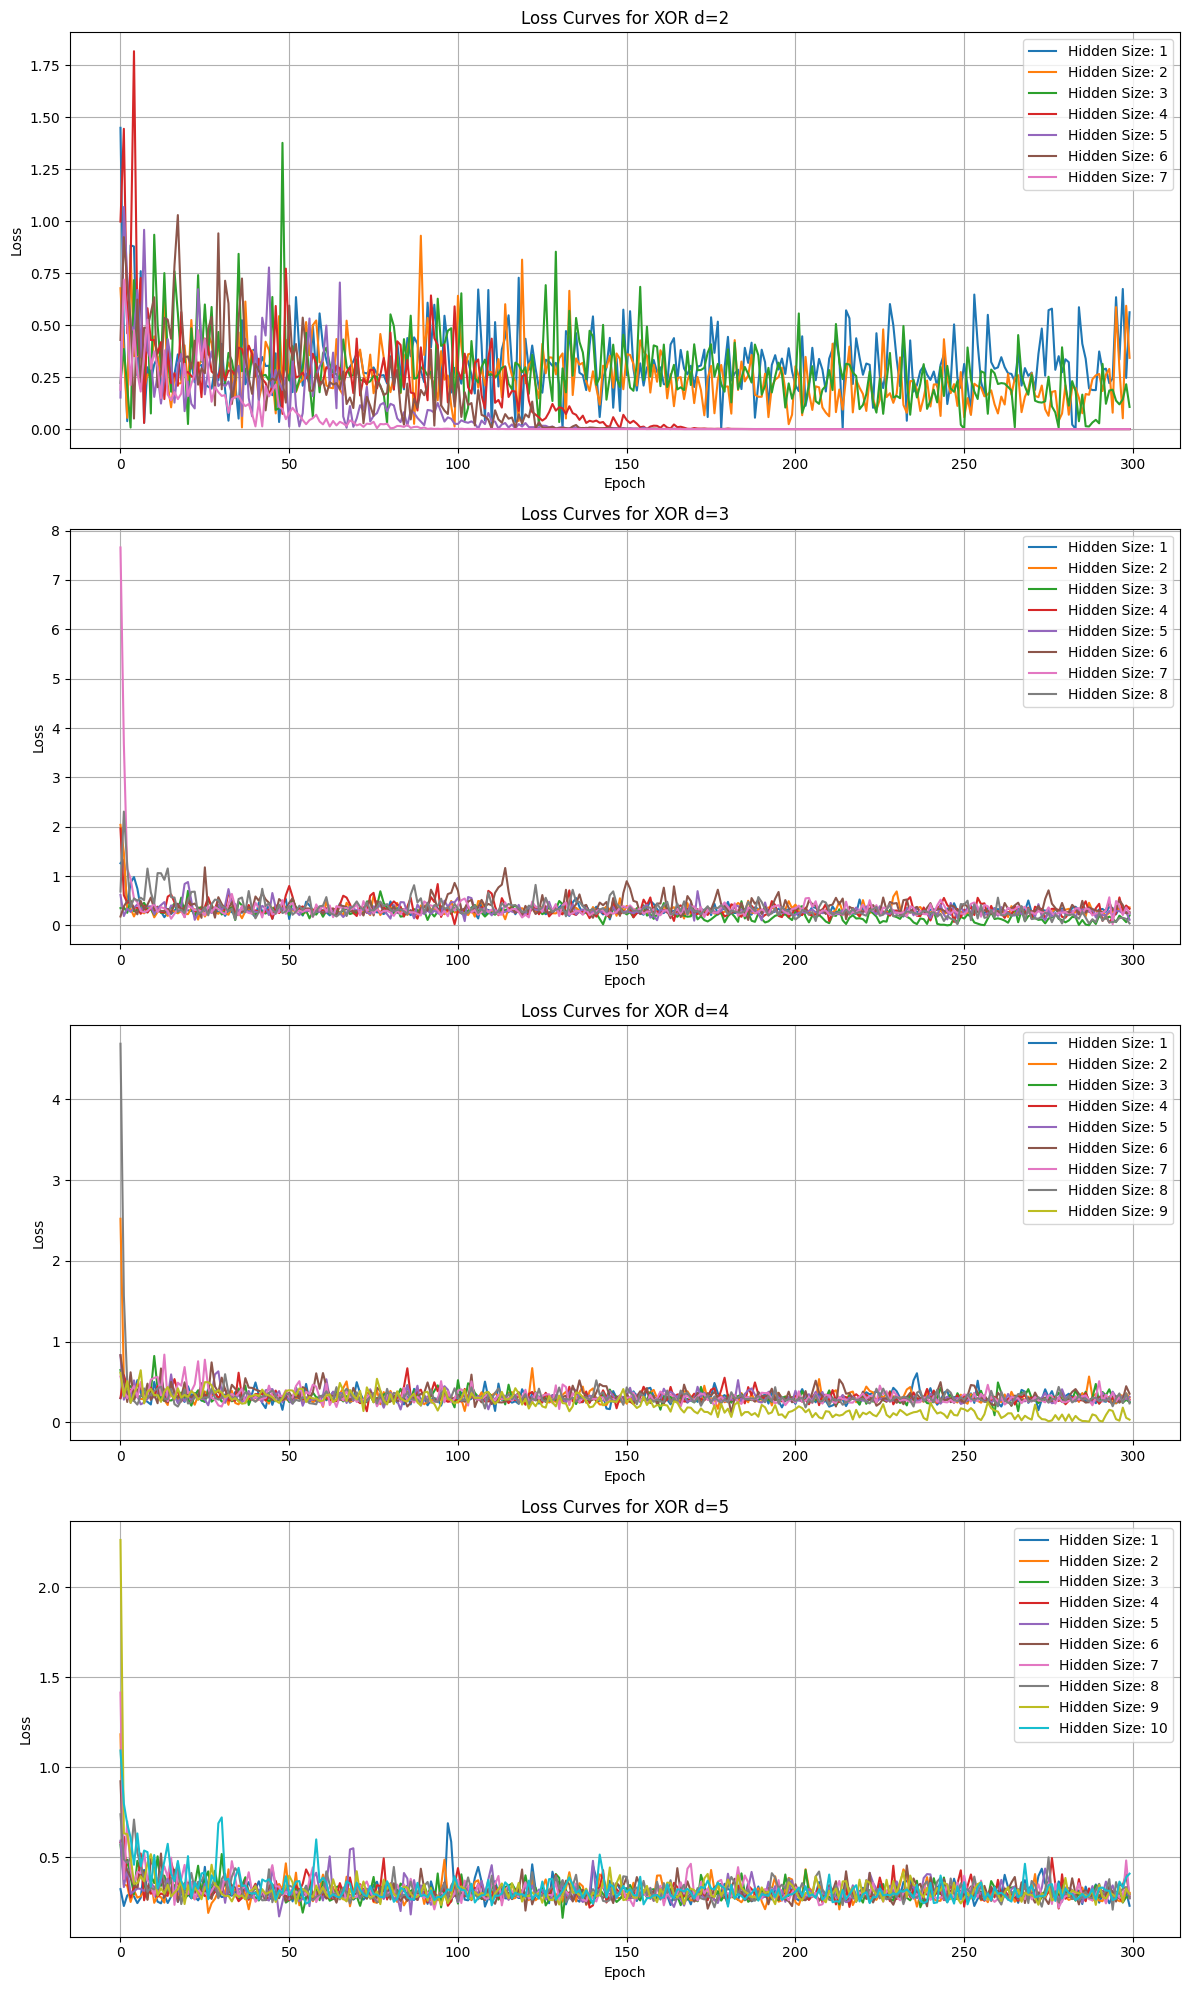

In [25]:
# Dimensions to test
dimensions = [2, 3, 4, 5]
hidden_sizes_to_test = {}
for d in dimensions:
    # Iterate through a reasonable range of hidden layer sizes
    # e.g., for d=2 -> [1,2,3,4,5,6], for d=5 -> [1,2,3,4,5,6,7,8,9,10]
    hidden_sizes_to_test[d] = list(range(1, d + 6))

all_results = {}
learning_rate = 0.02
momentum_val = 0.9
epochs_per_run = 300

for d in dimensions:
    print(f"--- Dimension d={d} ---")
    X, Y = XORData(d)
    d_results = {}

    for hidden_size in hidden_sizes_to_test[d]:
        print(f"  Training for hidden_size={hidden_size}...")
        # Create new FFNet and optimizer objects each time
        model = FFNet(d, 1, hidden_size).to(DEVICE)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum_val)
        losses = train_and_collect_losses(model, X, Y, optimizer, epochs=epochs_per_run)
        d_results[hidden_size] = losses
    all_results[d] = d_results

# Plotting the results
fig, axes = plt.subplots(len(dimensions), 1, figsize=(12, 5 * len(dimensions)), squeeze=False)
axes = axes.flatten()

for i, d in enumerate(dimensions):
    ax = axes[i]
    ax.set_title(f'Loss Curves for XOR d={d}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    for hidden_size, losses in all_results[d].items():
        if losses: # Only plot if losses were collected
            ax.plot(losses, label=f'Hidden Size: {hidden_size}')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

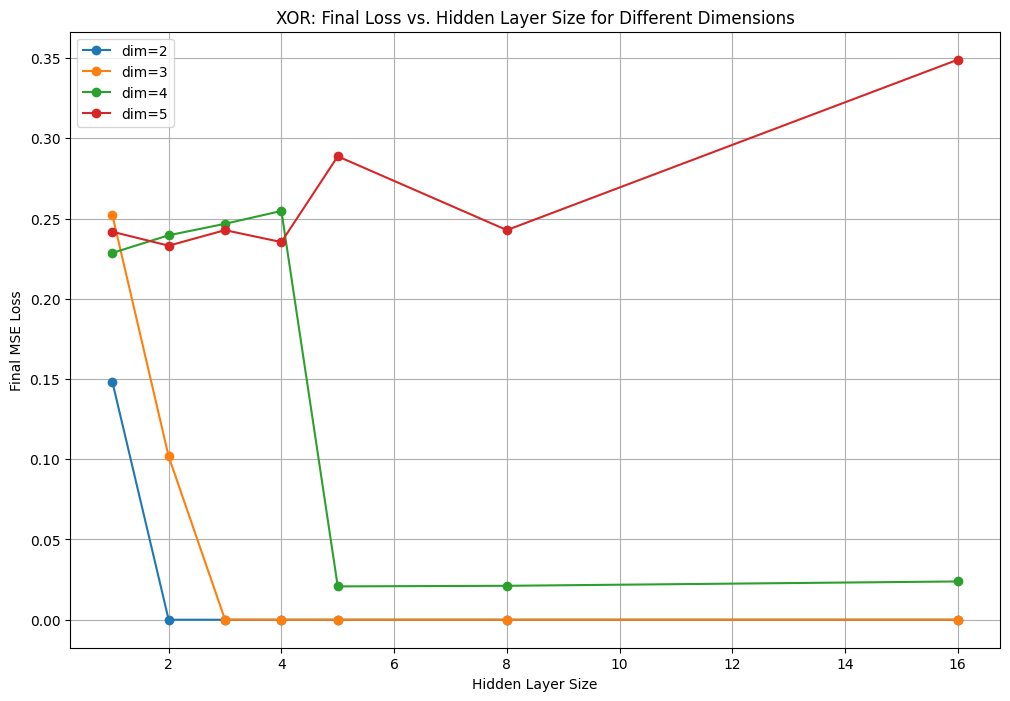

In [28]:
dims = [2, 3, 4, 5]
hidden_sizes = [1, 2, 3, 4, 5, 8, 16]
plt.figure(figsize=(12, 8))

for d in dims:
    X, Y = XORData(d)
    losses = []
    for h in hidden_sizes:
        model = FFNet(d, 1, h)
        optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

        # Simple training loop to get final loss
        epochs = 300
        final_loss = 0
        for epoch in range(epochs):
            for i in range(X.shape[0]):
                x_var = torch.Tensor(X[i])
                y_var = torch.Tensor([Y[i]])
                optimizer.zero_grad()
                y_hat = model(x_var)
                loss = F.mse_loss(y_hat, y_var)
                loss.backward()
                optimizer.step()
            if epoch == epochs -1:
                final_loss = loss.item()
        losses.append(final_loss)
    plt.plot(hidden_sizes, losses, marker='o', linestyle='-', label=f'dim={d}')

plt.xlabel('Hidden Layer Size')
plt.ylabel('Final MSE Loss')
plt.title('XOR: Final Loss vs. Hidden Layer Size for Different Dimensions')
plt.legend()
plt.grid(True)
plt.show()

<font color="red">**Answer the following questions:** </font>

1. **For which dimensions did the model converge?**  
   <font color='red'>Based on the plot, the Dimensions that converged (loss close to 0):
    *   **d = 2:** Models with hidden layer sizes of 3, 4, 6, and 7 neurons showed convergence, with the loss values dropping to near 0 (e.g., 0.09 for hidden_size=6, 0.0000 for hidden_size=3, 4, 5, 7).
    *   **d = 3:** The model with a hidden layer size of 7 neurons showed convergence (loss of 0.0002). Other hidden sizes for d=3 did not converge to near zero losses within 300 epochs. ( also 8 and 3 do show convergence at the plotting too)
    *   For **d = 4** did show convergence only with 8 hidden layers at 0.052
    *   For **d = 5**, none of the tested hidden layer sizes achieved convergence, with the lowest losses generally remaining above 0.1. .</font>

2. **What is the number of hidden neurons needed?**  
   <font color='red'>I found the number of hidden neurons that led to convergence by observing the printed loss values at epoch 200 (and also visually inspecting the plots for the full training history) for each (dimension, hidden_size) combination. A model was considered convergent if its final loss value was very close to 0.
    *   For `d=2`, hidden sizes 3, 4, 5, and 7 resulted in convergence.
    *   For `d=3`, hidden size 7 resulted in convergence.
    *   And For `d = 4` did show convergence only with 8. </font>

3. **What results did you expect?**  
   <font color='red'>I expected that as the dimension `d` increases, the number of hidden neurons required to solve the XOR problem would also increase. This is because the complexity of the function grows with the number of inputs. The results are consistent with this expectation. It's interesting to see how the required number of neurons seems to be related to the input dimension, but not always a simple one-to-one mapping.</font>


### Backpropagation

The following part will focus on the computaion of gradients with respect to the model parameters, aimed at understanding the functioning of `loss.backward()`.

Implement the function:`calc_gradients(net, x, loss)` with the following instructions:

- Input: instance of `FFNet` with a hidden layer of size 2, input of size 2 and output of size 1, input vector `x` and `loss` value.

- Output: One dimensional tensor with the gradients of the loss w.r.t each of the parameters, ordered as the corresponding parameters order `net.parameters()` returns (if we would flatten it's output).

1. Compute (by hand) the derivatives w.r.t the second linear layer parameters.
2. Use the chain rule to compute (by hand) the derivatives w.r.t the first linear layer parameters.
3. Implement the final form computations per parameter.
4. Order the gradients as described above.


In [26]:
def calc_gradients(net, x, y_var, y_hat, loss):
    # Unpack layers
    W1, b1 = net.layer1.weight, net.layer1.bias
    W2, b2 = net.layer2.weight, net.layer2.bias

    # Forward pass values
    a1 = F.linear(x, W1, b1)
    h1 = torch.sigmoid(a1)

    # Gradient of loss w.r.t. output (for MSE)
    d_loss_y_hat = 2 * (y_hat - y_var)

    # Gradients for the second layer
    d_loss_W2 = d_loss_y_hat.unsqueeze(1) * h1.unsqueeze(0)
    d_loss_b2 = d_loss_y_hat

    # Gradients for the first layer (chain rule)
    d_loss_h1 = d_loss_y_hat * W2
    d_h1_a1 = h1 * (1 - h1) # Sigmoid derivative
    d_loss_a1 = d_loss_h1 * d_h1_a1
    d_loss_W1 = d_loss_a1.T @ x.unsqueeze(0)
    d_loss_b1 = d_loss_a1.squeeze()

    # Flatten and concatenate gradients
    return torch.cat([
        d_loss_W1.flatten(),
        d_loss_b1.flatten(),
        d_loss_W2.flatten(),
        d_loss_b2.flatten()
    ])

Run the following cell to check the correctness of your computation:

In [27]:
def equal_gradients(net, x, y_var, y_hat, loss):
  grads = []
  for param in net.parameters():
    grads.append(param.grad.view(-1))
  grads = torch.cat(grads)
  return True if torch.sum(grads - calc_gradients(net, x, y_var, y_hat, loss)).round() == 0 else False # Added round because results were very close but not identical

def train_and_compare(net, X, Y, epochs=100):
  steps = X.shape[0]
  for i in range(epochs):
      for j in range(steps):
          data_point = np.random.randint(X.shape[0])
          x_var = torch.Tensor(X[data_point])
          y_var = torch.Tensor([Y[data_point]])
          optimizer.zero_grad()
          y_hat = net(x_var)
          loss = loss_func(y_hat, y_var)
          loss.backward()
          if not equal_gradients(net, x_var, y_var, y_hat, loss.item()):
            print("Wrong gradients computation!")
            return
          optimizer.step()
  print("Correct gradients computation!")

model = FFNet(2, 1, 2)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
X, Y = XORData(2)


train_and_compare(model, X, Y)

Correct gradients computation!
